## 設置環境和項目配置：安裝必要的套件，設置Google Cloud項目和BigQuery客戶端

In [1]:
# 安裝必要的套件
# %pip install -U langchain_google_vertexai langgraph google-cloud-aiplatform google-cloud-bigquery

import json
from typing import Annotated, Dict, Optional

from pydantic import BaseModel, Field

from google.cloud import bigquery

from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from langchain_core.tools import tool
from langchain_google_vertexai import ChatVertexAI

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display
from typing_extensions import TypedDict

# 設置 Google Cloud 項目ID和區域
PROJECT_ID = "poc-55-genai"
REGION = "US"

# 設置 GA4 資料集資訊
DATASET_ID = "bigquery-public-data.ga4_obfuscated_sample_ecommerce"
TABLE_PATTERN = "events_*"

# 設置 Google Cloud 項目
# ! gcloud config set project {PROJECT_ID}

# 初始化 BigQuery 客戶端
client = bigquery.Client()

## 階段2: 定義schema獲取函數

In [2]:
def get_schema() -> str:
    """Returns a simplified and structured GA4 schema for e-commerce analysis."""
    
    schema = {
        "dataset": "bigquery-public-data.ga4_obfuscated_sample_ecommerce",
        "table_pattern": "events_*",
        "description": "Google Analytics 4 e-commerce sample data containing shopping behaviors from Nov 2020 to Jan 2021",
        
        "core_fields": {
            "event_date": {
                "type": "STRING",
                "description": "Date of the event in YYYYMMDD format"
            },
            "event_timestamp": {
                "type": "INTEGER",
                "description": "Timestamp in microseconds (UTC). Divide by 1,000,000 to convert to seconds"
            },
            "event_name": {
                "type": "STRING",
                "description": "Name of the event (purchase, view_item, etc.)"
            },
            "user_pseudo_id": {
                "type": "STRING",
                "description": "Unique identifier for user/client instance"
            },
            "user_id": {
                "type": "STRING",
                "description": "ID for logged-in users"
            },
            "user_first_touch_timestamp": {
                "type": "INTEGER",
                "description": "First interaction timestamp in microseconds"
            }
        },
        
        "ecommerce_fields": {
            "ecommerce.transaction_id": {
                "type": "STRING",
                "description": "Unique transaction identifier"
            },
            "ecommerce.purchase_revenue": {
                "type": "FLOAT",
                "description": "Total revenue of the purchase in local currency"
            },
            "ecommerce.purchase_revenue_in_usd": {
                "type": "FLOAT",
                "description": "Total revenue in USD"
            },
            "ecommerce.shipping_value": {
                "type": "FLOAT",
                "description": "Shipping cost in local currency"
            },
            "ecommerce.tax_value": {
                "type": "FLOAT",
                "description": "Tax amount in local currency"
            },
            "ecommerce.total_item_quantity": {
                "type": "INTEGER",
                "description": "Total number of items in the transaction"
            },
            "ecommerce.unique_items": {
                "type": "INTEGER",
                "description": "Number of unique items in the transaction"
            }
        },
        
        "items_array": {
            "type": "REPEATED RECORD",
            "description": "Array of product items involved in the event",
            "fields": {
                "items.item_id": {
                    "type": "STRING",
                    "description": "Product identifier"
                },
                "items.item_name": {
                    "type": "STRING",
                    "description": "Product name"
                },
                "items.item_brand": {
                    "type": "STRING",
                    "description": "Product brand"
                },
                "items.item_category": {
                    "type": "STRING",
                    "description": "Product category"
                },
                "items.price": {
                    "type": "FLOAT",
                    "description": "Product price in local currency"
                },
                "items.quantity": {
                    "type": "INTEGER",
                    "description": "Quantity of the item"
                },
                "items.item_revenue": {
                    "type": "FLOAT",
                    "description": "Revenue for this item (price × quantity)"
                },
                "items.coupon": {
                    "type": "STRING",
                    "description": "Coupon code applied to the item"
                }
            }
        },
        
        "traffic_sources": {
            "traffic_source.source": {
                "type": "STRING",
                "description": "Traffic source (e.g., google, direct)"
            },
            "traffic_source.medium": {
                "type": "STRING",
                "description": "Traffic medium (e.g., organic, cpc, email)"
            },
            "traffic_source.name": {
                "type": "STRING",
                "description": "Campaign name"
            }
        },
        
        "device_fields": {
            "device.category": {
                "type": "STRING",
                "description": "Device type (mobile, tablet, desktop)"
            },
            "device.operating_system": {
                "type": "STRING",
                "description": "Operating system of the device"
            },
            "device.web_info.browser": {
                "type": "STRING",
                "description": "Web browser used"
            }
        },
        
        "event_params": {
            "type": "REPEATED RECORD",
            "description": "Event-specific parameters in key-value format",
            "access_pattern": "SELECT (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'page_location') AS page_url",
            "common_keys": [
                "page_location", 
                "page_title", 
                "page_referrer", 
                "engagement_time_msec", 
                "session_id"
            ]
        },
        
        "key_e_commerce_events": {
            "page_view": "User views a page",
            "view_item": "User views a product",
            "view_item_list": "User views a list of products",
            "add_to_cart": "User adds an item to cart",
            "begin_checkout": "User begins checkout process",
            "add_shipping_info": "User adds shipping information",
            "add_payment_info": "User adds payment information",
            "purchase": "User completes a purchase"
        },
        
        "common_analysis_patterns": {
            "purchase_funnel": "Track conversion through view_item → add_to_cart → begin_checkout → purchase",
            "revenue_analysis": "Calculate revenue by source, product, or time period",
            "cart_abandonment": "Identify users who added items to cart but did not purchase",
            "product_performance": "Analyze which products generate the most revenue or have highest conversion"
        },
        
        "query_tips": {
            "unnest_items": "Use UNNEST(items) AS item to access product details",
            "extract_params": "Use SELECT ... FROM UNNEST(event_params) WHERE key = 'param_name' to extract specific parameters",
            "timestamp_conversion": "Divide event_timestamp by 1,000,000 to convert from microseconds to seconds",
            "session_analysis": "Group by (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') to analyze by session"
        }
    }
    
    # 也可以添加一些示例查詢，以幫助LLM更好地理解如何使用GA4數據
    example_queries = [
        {
            "question": "What is the total revenue from purchases?",
            "query": """
            SELECT 
                SUM(ecommerce.purchase_revenue) AS total_revenue 
            FROM 
                `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` 
            WHERE 
                event_name = 'purchase'
            """
        },
        {
            "question": "What is the conversion rate from view to purchase?",
            "query": """
            WITH 
            viewers AS (
                SELECT 
                    COUNT(DISTINCT user_pseudo_id) as total_viewers
                FROM 
                    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
                WHERE 
                    event_name = 'view_item'
            ),
            purchasers AS (
                SELECT 
                    COUNT(DISTINCT user_pseudo_id) as total_purchasers
                FROM 
                    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
                WHERE 
                    event_name = 'purchase'
            )
            SELECT 
                total_viewers,
                total_purchasers,
                (total_purchasers / total_viewers) * 100 as conversion_rate_percent
            FROM 
                viewers, purchasers
            """
        }
    ]
    
    schema["example_queries"] = example_queries
    
    return json.dumps(schema, indent=2)

## 階段3: 定義工具


In [3]:
@tool
def execute_query_tool(query: str) -> str:
    """Execute a SQL query against BigQuery and return the results as a JSON string."""
  
    client = bigquery.Client()
    try:
        result = client.query(query)
        rows = [dict(row) for row in result]
        
        # Handle nested structures and special types for JSON serialization
        for row in rows:
            for key, value in row.items():
                if hasattr(value, 'isoformat'):  # Handle datetime objects
                    row[key] = value.isoformat()
                    
        return json.dumps(rows, default=str)
    except Exception as e:
        error_message = f"BigQuery Error: {str(e)}"
        return json.dumps({"BigQuery error": error_message})

class SubmitFinalAnswer(BaseModel):
    """Represents the final answer submitted by the agent."""
    
    final_answer: str = Field(..., description="The final answer to submit to the user")

# Initialize LLM and bind tools
MODEL = "gemini-1.5-flash"  # You can use other models like "gemini-1.5-pro" if needed

# Create a base LLM object with the Gemini model and bind tools
data_llm_with_tools = ChatVertexAI(model=MODEL).bind_tools([execute_query_tool, SubmitFinalAnswer])

# Define memory for state persistence
memory = MemorySaver()

# Define State for the workflow
class State(TypedDict):
    """Defines the LangGraph workflow state."""
    
    messages: Annotated[list[AnyMessage], add_messages]
    dataset_schema: Optional[str]

Failed to convert project number to project ID.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/google/cloud/aiplatform/initializer.py", line 101, in _set_project_as_env_var_or_google_auth_default
    project_id = resource_manager_utils.get_project_id(
  File "/opt/conda/lib/python3.10/site-packages/google/cloud/aiplatform/utils/resource_manager_utils.py", line 48, in get_project_id
    project = projects_client.get_project(name=f"projects/{project_number}")
  File "/opt/conda/lib/python3.10/site-packages/google/cloud/resourcemanager_v3/services/projects/client.py", line 781, in get_project
    response = rpc(
  File "/opt/conda/lib/python3.10/site-packages/google/api_core/gapic_v1/method.py", line 131, in __call__
    return wrapped_func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/google/api_core/retry/retry_unary.py", line 293, in retry_wrapped_func
    return retry_target(
  File "/opt/conda/lib/python3.10/site-packages/google/

## 階段4: 建立系統提示和節點函數

In [7]:
def get_schema_node(state: Dict) -> Dict:
    """Retrieves the schema and stores it in the state."""
    
    if state.get("dataset_schema") is None: 
        schema = get_schema()
        return {"dataset_schema": schema, "messages": [AIMessage(content="GA4 e-commerce schema loaded and ready for analysis.")]}
    return {"messages": [AIMessage(content="Using cached GA4 e-commerce schema.")]}

def data_chatbot_node(state: Dict) -> Dict:
    """Uses LLM to understand user requests and generate appropriate responses."""
    
    schema = state["dataset_schema"]
    messages = [SystemMessage(content=sys_message.format(schema=schema))] + state["messages"]
    response = data_llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [8]:
# 修正系統提示，使其更清晰地理解GA4數據集的查詢方式
sys_message = """You are an expert in e-commerce analytics using GA4 (Google Analytics 4) data. Your job is to help users analyze e-commerce data stored in BigQuery by executing relevant SQL queries. The user is interested in understanding their data and getting valuable insights.

1. If the user request is reasonable and compatible with the schema, YOU MUST FIRST call the `execute_query_tool` to get the result.
   When generating the SQL query:
   - Use meaningful aliases for column names
   - Limit results to 5-10 rows (unless specified)
   - Order results for clarity
   - Select only necessary columns; avoid SELECT *
   - Use valid BigQuery SQL
   - Use only SELECT statements (no DML)
   - Remember that GA4 event_timestamp is in microseconds, divide by 1,000,000 to convert to seconds
   - Use UNNEST() to handle nested fields like items and event_params
   - Date format is YYYYMMDD, use PARSE_DATE() if needed for formatting
   - For the GA4 data, always use the table pattern: `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
   - Always use backticks around table names (`) when referring to BigQuery tables

2. Call the `execute_query_tool` to execute the generated SQL query. If the query fails, analyze the error message and attempt to correct the SQL. If correction is not possible, inform the user of the error and its likely cause.

3. After you have the result from BigQuery, you MUST call the `SubmitFinalAnswer` tool to present the final results to the user in a clear, easy-to-understand format. Include actionable insights based on the data whenever possible. ALWAYS call SubmitFinalAnswer after getting query results.

You will use the following schema for all queries and all SQL must conform to this schema: {schema}

**Example:**
If a user asks: "What's our total revenue from the last month?" you should:
1. Call the execute_query_tool to execute SQL like: 'SELECT SUM(ecommerce.purchase_revenue) as total_revenue FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` WHERE event_name = "purchase" AND PARSE_DATE("%Y%m%d", event_date) >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY) LIMIT 1'
2. Then call SubmitFinalAnswer to respond with something like: "Based on the data, your total revenue for the last month was $X. This represents an important metric for understanding your overall business performance."

Remember to focus on e-commerce analysis such as:
- Purchase funnel analysis (view_item → add_to_cart → begin_checkout → purchase)
- Customer journey and behavior patterns
- Conversion rates at different stages
- Product performance analysis
- Traffic source effectiveness
- Device/platform impact on purchase behavior
"""

# 修正get_state函數，確保代理能夠正確地流轉到終止狀態
def get_state(state: Dict) -> str:
    """Determines the next steps in the workflow based on the last message."""
    
    last_message = state["messages"][-1]     

    if isinstance(last_message, AIMessage) and hasattr(last_message, "tool_calls") and last_message.tool_calls:
        if any(tool_call["name"] == "execute_query_tool" for tool_call in last_message.tool_calls):
            return "execute_sql"
        elif any(tool_call["name"] == "SubmitFinalAnswer" for tool_call in last_message.tool_calls):
            return END
        else:
            return "data_chatbot"
    else:
        # 如果沒有工具調用，則繼續使用聊天機器人
        return "data_chatbot"

# 重新定義工作流
workflow = StateGraph(State)

workflow.add_node("get_schema", get_schema_node)
workflow.add_node("data_chatbot", data_chatbot_node)
workflow.add_node("execute_sql", ToolNode([execute_query_tool]))
workflow.add_node("submit_answer", ToolNode([SubmitFinalAnswer]))

workflow.add_edge(START, "get_schema")
workflow.add_edge("get_schema", "data_chatbot")
workflow.add_conditional_edges(
    "data_chatbot", 
    get_state, 
    {
        "execute_sql": "execute_sql",
        "data_chatbot": "data_chatbot",
        END: END
    }
)
workflow.add_edge("execute_sql", "data_chatbot")
workflow.add_edge("submit_answer", END)

# 重新編譯工作流
data_chatbot_graph = workflow.compile(checkpointer=memory)


In [9]:

    
def get_state(state: Dict) -> str:
    """Determines the next steps in the workflow based on the last message."""
    
    last_message = state["messages"][-1]     

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        if any(tool_call["name"] == "execute_query_tool" for tool_call in last_message.tool_calls):
            return "execute_sql"
        elif any(tool_call["name"] == "SubmitFinalAnswer" for tool_call in last_message.tool_calls):
            return END

    return "data_chatbot"

## 階段5: 構建工作流

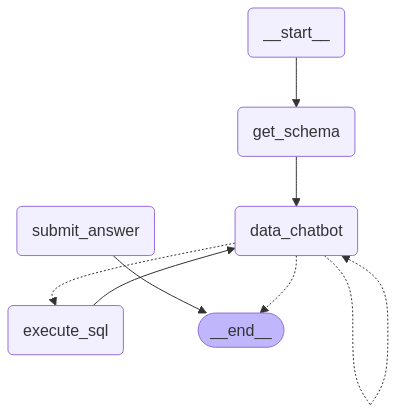

In [10]:
# Define the workflow using StateGraph
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("get_schema", get_schema_node)
workflow.add_node("data_chatbot", data_chatbot_node)
workflow.add_node("execute_sql", ToolNode([execute_query_tool]))
workflow.add_node("submit_answer", ToolNode([SubmitFinalAnswer]))

# Define the edges of the graph
workflow.add_edge(START, "get_schema")
workflow.add_edge("get_schema", "data_chatbot")
workflow.add_conditional_edges(
    "data_chatbot", 
    get_state, 
    {
        "execute_sql": "execute_sql",
        "data_chatbot": "data_chatbot",
        END: END
    }
)
workflow.add_edge("execute_sql", "data_chatbot")
workflow.add_edge("submit_answer", END)

# Compile the workflow into a runnable graph
data_chatbot_graph = workflow.compile(checkpointer=memory)

# Optionally visualize the graph (if running in a Jupyter notebook)
try:
    display(Image(data_chatbot_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Unable to display graph visualization: {e}")
    print("This is normal if not running in a Jupyter notebook with proper dependencies installed.")

In [11]:
# 改進的run_agent函數，增加超時處理
def run_agent(user_input, thread_id="e_commerce_analytics"):
    """Execute the agent with given user input and return results."""
    
    config = {
        "configurable": {"thread_id": thread_id},
        "recursion_limit": 10  # 降低遞歸限制以更快地捕獲問題
    }
    
    try:
        messages = []
        for output in data_chatbot_graph.stream(
            {"messages": [HumanMessage(content=user_input)]},
            config=config,
            stream_mode="updates"
        ):
            last_message = next(iter(output.values()))["messages"][-1]
            messages.append(last_message)
            
            # 如果這是一個帶有內容的AI消息，打印它
            if isinstance(last_message, AIMessage) and hasattr(last_message, "content") and last_message.content:
                print(f"AI: {last_message.content}")
                
            # 如果這是一個帶有工具調用的AI消息，打印工具調用
            if isinstance(last_message, AIMessage) and hasattr(last_message, "tool_calls") and last_message.tool_calls:
                for tool_call in last_message.tool_calls:
                    tool_name = tool_call.get("name", "Unknown tool")
                    if tool_name == "execute_query_tool":
                        # 正確處理args參數
                        query = str(tool_call.get('args', {}).get('query', ''))
                        print(f"Executing SQL query: {query[:150]}...")
                    elif tool_name == "SubmitFinalAnswer":
                        final_answer = tool_call.get("args", {}).get("final_answer", "")
                        print(f"Final Answer: {final_answer}")
        
        return messages[-1] if messages else None
    
    except Exception as e:
        print(f"Error during agent execution: {str(e)}")
        print("Let me try to simplify and answer your question directly.")
        
        # 作為備份，直接使用LLM回答問題
        backup_response = ChatVertexAI(model=MODEL).invoke(
            [
                SystemMessage(content="You are an e-commerce analytics expert. Answer this question based on GA4 data."),
                HumanMessage(content=user_input)
            ]
        )
        print(f"AI Backup Response: {backup_response.content}")
        return backup_response

# 測試具體問題
example_questions = [
    "How many unique users are there in our dataset?",
    "What's the total revenue from purchases?",
    "What is the conversion rate from product view to purchase?"
]

# 單獨測試
question = "How many unique users are there in our dataset?"
print(f"\nQuestion: {question}")
run_agent(question)


Question: How many unique users are there in our dataset?
AI: GA4 e-commerce schema loaded and ready for analysis.
Executing SQL query: SELECT COUNT(DISTINCT user_pseudo_id) AS unique_users FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LIMIT 1...
Final Answer: There are 270,154 unique users in the dataset. This gives you a good base for analyzing user behavior and engagement.


AIMessage(content='', additional_kwargs={'function_call': {'name': 'SubmitFinalAnswer', 'arguments': '{"final_answer": "There are 270,154 unique users in the dataset. This gives you a good base for analyzing user behavior and engagement."}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.10107421875, 'blocked': False, 'severity': 'HARM_SEVERITY_LOW', 'severity_score': 0.25390625}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.1083984375, 'blocked': False, 'severity': 'HARM_SEVERITY_LOW', 'severity_score': 0.2236328125}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.2119140625, 'blocked': False, 'severity': 'HARM_SEVERITY_LOW', 'severity_score': 0.25}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.1113281

In [12]:

# Create an interactive interface for the notebook
def interactive_chat():
    """Provide an interactive interface for chatting with the agent."""
    
    print("=== E-commerce Analytics Assistant ===")
    print("Ask questions about GA4 e-commerce data. Type 'exit' or 'quit' to end the session.")
    print("Example questions:")
    print("- What's our total revenue?")
    print("- How many users viewed products but didn't purchase?")
    print("- What are the top traffic sources for purchases?")
    print("- Show me the conversion rate by device type")
    print("-----------------------------------------")
    
    thread_id = f"ecommerce_{hash(str(datetime.now()))}"
    
    while True:
        user_input = input("\nYou: ")
        
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Chat session ended. Thank you!")
            break
            
        print("\nAI is thinking...")
        run_agent(user_input, thread_id=thread_id)
        print("-----------------------------------------")

# Add missing import for datetime
from datetime import datetime



In [15]:
# Uncomment the line below to start the interactive chat
interactive_chat()

=== E-commerce Analytics Assistant ===
Ask questions about GA4 e-commerce data. Type 'exit' or 'quit' to end the session.
Example questions:
- What's our total revenue?
- How many users viewed products but didn't purchase?
- What are the top traffic sources for purchases?
- Show me the conversion rate by device type
-----------------------------------------



You:  how many events happened in the peroid?



AI is thinking...
AI: GA4 e-commerce schema loaded and ready for analysis.
Executing SQL query: 
SELECT
    COUNT(*) AS event_count
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
LIMIT 1
...
Final Answer: There were 4,295,584 events recorded in the dataset.
-----------------------------------------



You:  how many days included in this dataset?



AI is thinking...
AI: Using cached GA4 e-commerce schema.
Executing SQL query: 
SELECT
    COUNT(DISTINCT event_date) AS distinct_days
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
LIMIT 1
...
Final Answer: This dataset includes data for 92 unique days.
-----------------------------------------


KeyboardInterrupt: Interrupted by user